In [11]:
import os
import sys
from importlib import reload
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
        
from time import time 
import csv

import numpy as np
import scipy as sc
import pandas as pd
from sklearn.model_selection import train_test_split

import rna
import models
import utils

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["font.size"] = 12

import seaborn as sns
sns.set_style('darkgrid')

In [138]:
# generate training data
reload(rna)
n_train = 5000
p_mut = 0.1
noise_sd = 0.02

rnabind = rna.RNABinding()
trainseq_n, ytrain_n = rnabind.get_training_data(
    n_train,
    p_mut,
    noise_sd=noise_sd
)
testseq_n, ytest_n = rnabind.get_training_data(
    n_train,
    p_mut,
    noise_sd=noise_sd
)

Generating 5000 labeled sequences...
Done. (55 s)
Generating 5000 labeled sequences...
Done. (55 s)


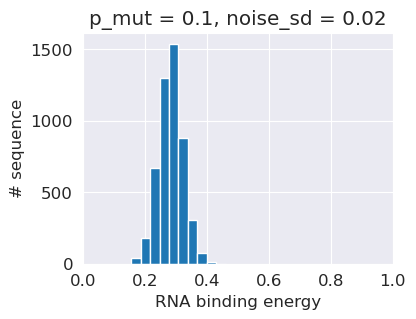

In [139]:
plt.figure(figsize=(4, 3))
plt.hist(ytrain_n)
plt.xlabel('RNA binding energy');
plt.ylabel('# sequence');
plt.title('p_mut = {}, noise_sd = {}'.format(p_mut, noise_sd));
plt.xlim([0, 1]);

CV-selected alpha: 10.0


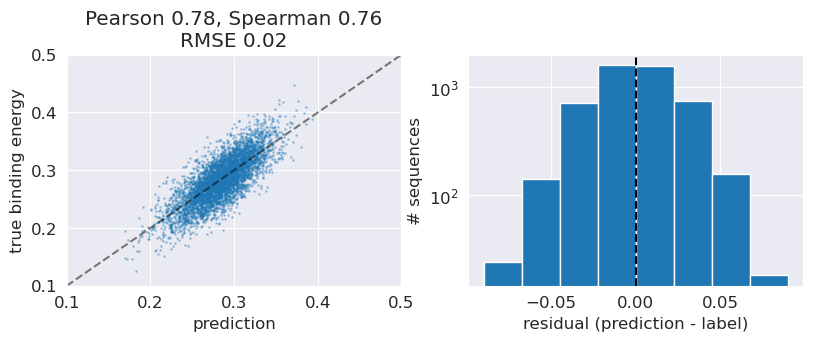

In [140]:
reload(models)
model = models.RidgeRegressor(seq_len=50, alphabet=rna.RNA_NUCLEOTIDES)
model.fit(trainseq_n, ytrain_n)
print(f'CV-selected alpha: {model.model.alpha_}')
predtest_n = model.predict(testseq_n)

xy_lim = [0.1, 0.5]
plt.figure(figsize=(9.5, 3))
plt.subplot(121)
plt.scatter(predtest_n, ytest_n, alpha=0.3, s=1);
plt.plot(xy_lim, xy_lim, '--k', alpha=0.5)
r, p = sc.stats.pearsonr(ytest_n, predtest_n)
rho, p = sc.stats.spearmanr(ytest_n, predtest_n)
rmse = np.sqrt(np.mean(np.square(ytest_n - predtest_n)))

plt.ylim(xy_lim);
plt.xlim(xy_lim)
plt.title('Pearson {:.2f}, Spearman {:.2f}\nRMSE {:.2f}'.format(r, rho, rmse));
plt.ylabel('true binding energy'); plt.xlabel('prediction');

plt.subplot(122)
plt.hist(predtest_n - ytest_n, bins=8, log=True);
plt.ylabel('# sequences')
plt.axvline(0, linestyle='--', color='k')
plt.xlabel('residual (prediction - label)');

No fitness variance estimates provided. Using unweighted MSE loss.
One-hot encoded sequences to shape = (5000, 50, 4) (0 sec)
4500 training data points, 500 validation data points.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 108.63it/s]


Epoch 0. Train loss: 0.01. Val loss: 0.10. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 114.15it/s]


Epoch 1. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 121.04it/s]


Epoch 2. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 107.51it/s]


Epoch 3. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 123.20it/s]


Epoch 4. Train loss: 0.00. Val loss: 0.00. 0 sec.


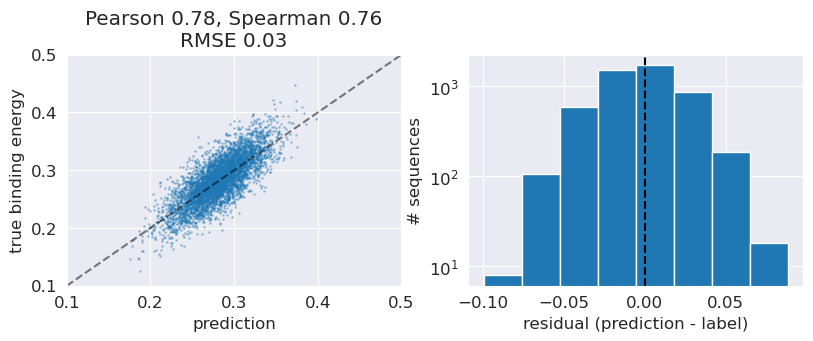

In [141]:
reload(models)
reload(rna)
n_hidden = 100
n_epoch = 5
lr = 0.001
model = models.FeedForward(50, rna.RNA_NUCLEOTIDES, n_hidden)
loss_tx2 = model.fit(
    trainseq_n,
    ytrain_n,
    n_epoch=n_epoch,
    lr=lr,
)

predtest_n = model.predict(testseq_n)

xy_lim = [0.1, 0.5]
plt.figure(figsize=(9.5, 3))
plt.subplot(121)
plt.scatter(predtest_n, ytest_n, alpha=0.3, s=1);
plt.plot(xy_lim, xy_lim, '--k', alpha=0.5)
r, p = sc.stats.pearsonr(ytest_n, predtest_n)
rho, p = sc.stats.spearmanr(ytest_n, predtest_n)
rmse = np.sqrt(np.mean(np.square(ytest_n - predtest_n)))

plt.ylim(xy_lim);
plt.xlim(xy_lim)
plt.title('Pearson {:.2f}, Spearman {:.2f}\nRMSE {:.2f}'.format(r, rho, rmse));
plt.ylabel('true binding energy'); plt.xlabel('prediction');

plt.subplot(122)
plt.hist(predtest_n - ytest_n, bins=8, log=True);
plt.ylabel('# sequences')
plt.axvline(0, linestyle='--', color='k')
plt.xlabel('residual (prediction - label)');

No fitness variance estimates provided. Using unweighted MSE loss.
One-hot encoded sequences to shape = (5000, 50, 4) (0 sec)
4500 training data points, 500 validation data points.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 57.87it/s]


Epoch 0. Train loss: 0.00. Val loss: 0.05. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 57.21it/s]


Epoch 1. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 59.82it/s]


Epoch 2. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 54.68it/s]


Epoch 3. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 55.51it/s]


Epoch 4. Train loss: 0.00. Val loss: 0.00. 1 sec.


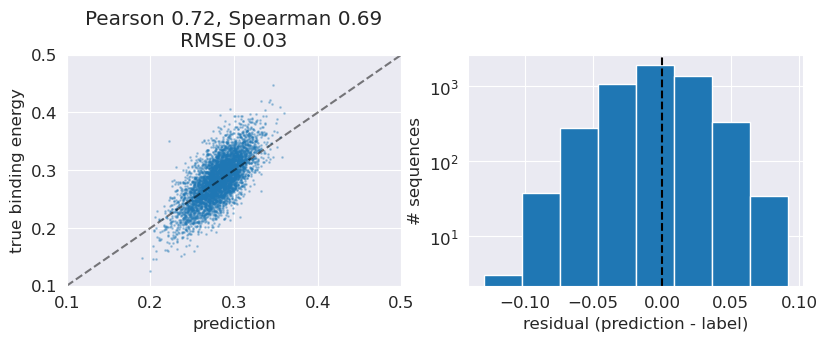

In [142]:
reload(models)
reload(rna)
n_filters = 32
n_hidden = 10
n_epoch = 5
lr = 0.001

model = models.CNN(50, rna.RNA_NUCLEOTIDES, n_filters, n_hidden)
loss_tx2 = model.fit(
    trainseq_n,
    ytrain_n,
    n_epoch=n_epoch,
    lr=lr,
)

predtest_n = model.predict(testseq_n)

xy_lim = [0.1, 0.5]
plt.figure(figsize=(9.5, 3))
plt.subplot(121)
plt.scatter(predtest_n, ytest_n, alpha=0.3, s=1);
plt.plot(xy_lim, xy_lim, '--k', alpha=0.5)
r, p = sc.stats.pearsonr(ytest_n, predtest_n)
rho, p = sc.stats.spearmanr(ytest_n, predtest_n)
rmse = np.sqrt(np.mean(np.square(ytest_n - predtest_n)))

plt.ylim(xy_lim);
plt.xlim(xy_lim)
plt.title('Pearson {:.2f}, Spearman {:.2f}\nRMSE {:.2f}'.format(r, rho, rmse));
plt.ylabel('true binding energy'); plt.xlabel('prediction');

plt.subplot(122)
plt.hist(predtest_n - ytest_n, bins=8, log=True);
plt.ylabel('# sequences')
plt.axvline(0, linestyle='--', color='k')
plt.xlabel('residual (prediction - label)');